本文主要以kaggle一次二分类竞赛数据为例，深入研究改进forest

LayerDTree是LayerForest的精简版，是对Forest进一步探索的基础

- 数据地址：https://www.kaggle.com/c/porto-seguro-safe-driver-prediction
- 数据特点：
  - 非常不均衡、缺失值严重、二分类
- 包含内容：
  1. 数据获取
  2. 模型应用
  3. 结果分析

# Stage-1：获取数据

In [4]:
import os
import numpy as np
import pandas as pd
import time
import os.path as osp

In [5]:
import DataHelper
import importlib
importlib.reload(DataHelper)

<module 'DataHelper' from 'C:\\github_workspace\\ecoForest\\DataHelper.py'>

In [6]:
X_train,y_train, X_sub, y_sub = DataHelper.get_adult_data()

X.shape: (32561, 14) y.shape: (32561,)
X.shape: (16281, 14) y.shape: (16281,)


In [7]:
# X_train,y_train, X_sub, y_sub = DataHelper.get_letter_data()

# Stage-2：模型应用

In [8]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import ForestUtils
import time
import random
from sklearn import metrics

In [9]:
import EnhancedDTree
import EnhancedForest
import importlib

In [10]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [11]:
def acc_prob(y_sub, p_train):
    threshold = [x*0.01 for x in range(30,71,1)]
    result = []
    for i in range(len(threshold)):
        test_y_acc_index = np.where(p_train > threshold[i])[0]
        test_y_acc = np.array([0] * len(p_train))
        test_y_acc[test_y_acc_index] = 1
        tmp = metrics.accuracy_score(y_sub, test_y_acc)
        result.append(tmp)
    result = np.array(result)
    return np.max(result)

# 决策树算法

In [10]:
clf = DecisionTreeClassifier()
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
clf = clf.fit(X_train, y_train)

In [24]:
p_train = clf.predict_proba(X_sub)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print("data auc", metrics.roc_auc_score(y_sub, p_train))
print("data log", metrics.log_loss(y_sub, p_train)) 
print("data acc", acc_prob(y_sub, p_train))

data auc 0.745391543044
data log 6.4025092895
data acc 0.814630550949


In [25]:
p_train = clf.predict(X_sub)
print("data auc", metrics.accuracy_score(y_sub, p_train))

data auc 0.814630550949


# 随机森林算法

In [26]:
# rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=4, random_state=1024, verbose=True, min_samples_leaf=10)
# rf

In [27]:
rf = RandomForestClassifier()
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
p_train = rf.predict_proba(X_sub)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print("data auc", metrics.roc_auc_score(y_sub, p_train))
print("data log", metrics.log_loss(y_sub, p_train))
print("data acc", acc_prob(y_sub, p_train))

data auc 0.88161776652
data log 0.858700589533
data acc 0.84792088938


In [30]:
p_train = rf.predict(X_sub)
print("data acc", metrics.accuracy_score(y_sub, p_train))
print("data log", metrics.log_loss(y_sub, p_train)) 

data acc 0.847859468092
data log 5.25478872274


# XGB算法

In [31]:
import xgboost as xgb

c:\program files\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
params = {
    'objective': 'binary:logistic',
#     'silent': True,
    
#     'max_depth': 4,
#     'eta': 0.020,
#     'gamma': 0.65,
    
#     'colsample_bytree': 0.8,
#     'subsample': 0.6,
    
#     'num_boost_round' : 700,
#     'min_child_weight': 10.0,
#     'max_delta_step': 1.8,
}

In [59]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n

def gini_normalized(a, p):
#     if p.ndim == 2:#Required for sklearn wrapper
#         p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

# Create an XGBoost-compatible metric from Gini
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [34]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=9487)
split_obj = tuple(sss.split(X_train, y_train))
train_index, test_index = split_obj[0]
X_1, X_2 = X_train[train_index], X_train[test_index]
y_1, y_2 = y_train[train_index], y_train[test_index]

In [60]:
# d_train = xgb.DMatrix(X_1, y_1)
# d_valid = xgb.DMatrix(X_2, y_2)
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_sub, y_sub)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

mdl = xgb.train(params, d_train, 
                    num_boost_round=1600, evals=watchlist, early_stopping_rounds=100, 
                    feval=gini_xgb, 
                maximize=True, verbose_eval=100)

[0]	train-gini:0.794988	valid-gini:0.787557
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-gini:0.923187	valid-gini:0.852141
Stopping. Best iteration:
[54]	train-gini:0.900821	valid-gini:0.854853



In [36]:
d_test = xgb.DMatrix(X_sub)
p_train = mdl.predict(d_test)
print("data auc", metrics.roc_auc_score(y_sub, p_train))
print("data log", metrics.log_loss(y_sub, p_train))
print("data acc", acc_prob(y_sub, p_train))

data auc 0.923257433715
data log 0.286904550439
data acc 0.86929549782


In [37]:
d_test = xgb.DMatrix(X_sub)
p_train = mdl.predict(d_test)
# print("data auc", metrics.roc_auc_score(y_sub, p_train))
# print("data log", metrics.log_loss(y_sub, p_train))
print("data acc", acc_prob(y_sub, p_train))
print("data acc", metrics.accuracy_score(y_sub, p_train))

data acc 0.86929549782


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [38]:
test_y_acc_index = np.where(p_train > 0.5)[0]
test_y_acc = np.array([0] * len(p_train))
test_y_acc[test_y_acc_index] = 1
metrics.accuracy_score(y_sub, test_y_acc)

0.86757570173822252

# GDBT算法

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
gdbt = GradientBoostingClassifier()
gdbt

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [41]:
gdbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [42]:
p_train = gdbt.predict_proba(X_sub)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print("data auc", metrics.roc_auc_score(y_sub, p_train))
print("data log", metrics.log_loss(y_sub, p_train))
print("data acc", acc_prob(y_sub, p_train))

data auc 0.921379650522
data log 0.290379478168
data acc 0.870032553283


In [43]:
p_train = gdbt.predict(X_sub)
print("data acc", metrics.accuracy_score(y_sub, p_train))
print("data log", metrics.log_loss(y_sub, p_train)) 

data acc 0.869111233954
data log 4.52076787981


# BaseLine

In [44]:
def acc_metrix_mult(a, p):
#     print(p)
    return "acc:", metrics.accuracy_score(a, p)

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import stats

In [46]:
kfold = 3
X = X_train.copy()
y = y_train.copy()
X_test = X_sub.copy()
real_y = y_sub.copy()
max_depth = None
random_state = None
min_samples_leaf = 1
criterion = 'entropy'#'gini'
num_class = 2
feval = acc_metrix_mult
n_estimators = 200

In [47]:
sss = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=9487)

p_all_fold = np.zeros(X.shape[0])
clf_folds = []
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    X_train_bl, X_valid_bl = X[train_index], X[test_index]
    y_train_bl, y_valid_bl = y[train_index], y[test_index]
        
    print("X_train.shape, y_train.shape:"+str(X_train_bl.shape)+str(y_train_bl.shape))
    print("X_valid.shape, y_valid.shape:"+str(X_valid_bl.shape)+str(y_valid_bl.shape))
        
    clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state, 
                                    min_samples_leaf=min_samples_leaf, n_estimators=n_estimators, n_jobs=-1,
                                         #max_leaf_nodes=100,
    #                                  n_estimators=2, n_jobs=8, oob_score=True, verbose=1, boostrap=False,
                                     criterion=criterion)
    clf = clf.fit(X_train_bl, y_train_bl)
    clf_folds.append(clf)
    print(clf)
    
#     cross_score = cross_val_score(clf, X_valid, y_valid, cv=3)
#     print("    cross_score: %.5f" % (cross_score.mean()))
    print("    test score", feval(real_y, clf.predict(X_test)))
    
    
    if not num_class:
        y_pred = clf.predict_proba(X_valid_bl)[:,1]
    else:
        y_pred = clf.predict(X_valid_bl)

    p_all_fold[test_index] += y_pred
feval(y, p_all_fold)

X_train.shape, y_train.shape:(21707, 14)(21707,)
X_valid.shape, y_valid.shape:(10854, 14)(10854,)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    test score ('acc:', 0.85424728210797862)
X_train.shape, y_train.shape:(21707, 14)(21707,)
X_valid.shape, y_valid.shape:(10854, 14)(10854,)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=

('acc:', 0.85854242805810632)

In [48]:
y_preds = np.zeros((X_test.shape[0], len(clf_folds)))
for i, clf in enumerate(clf_folds):
    if not num_class:
        y_pred = clf.predict_proba(X_test)[:,1]
    else:
        y_pred = clf.predict(X_test)
    y_preds[:, i] = y_pred

if not num_class:
    result = y_preds.mean(axis=1)
else:
    print(y_preds)
    m = stats.mode(y_preds, axis=1)
    result = np.array([i[0] for i in m[0]])
print(result)
feval(real_y, result)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]
 ..., 
 [ 1.  1.  1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]
[ 0.  0.  0. ...,  1.  0.  1.]


('acc:', 0.85670413365272402)

In [49]:
y_preds = np.zeros((X.shape[0], len(clf_folds)))
for i, clf in enumerate(clf_folds):
    if not num_class:
        y_pred = clf.predict_proba(X)[:,1]
    else:
        y_pred = clf.predict(X)
    y_preds[:, i] = y_pred

if not num_class:
    result = y_preds.mean(axis=1)
else:
    print(y_preds)
    m = stats.mode(y_preds, axis=1)
    result = np.array([i[0] for i in m[0]])
print(result)
feval(y, result)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 ..., 
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]
[ 0.  0.  0. ...,  0.  0.  1.]


('acc:', 0.99996928841251809)

# layerDTree算法

In [1]:
import datetime
import time

In [2]:
def acc_metrix(a, p):
    return "acc:", acc_prob(a, p)
def mse_metrix(a, p):
    return "mse:", metrics.mean_squared_error(a,p,labels=labels)
def log_loss_metrix(a, p, labels=[0,1]):
    return "log:", metrics.log_loss(a,p,labels=labels)

In [12]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [13]:
importlib.reload(EnhancedForest)

<module 'EnhancedForest' from 'C:\\github_workspace\\ecoForest\\EnhancedForest.py'>

In [20]:
# 统计信息
train_loss_lt = []
pass_train_loss_lt = []
pass_train_loss_lt_now = []
vaild_loss_lt = []
pass_vaild_loss_lt = []
pass_vaild_loss_lt_now = []
test_loss_lt = []
pass_test_loss_lt = []
pass_test_loss_lt_now = []
pass_data_rate_lt = []
pass_data_rate_test_lt = []

# 数据
X = X_train.copy()
y = y_train.copy()

X_test = X_sub.copy()
test_y = np.array(([0.0] * len(X_test)))
all_data_mask = np.array([False] * len(X_test))
data_mask = np.array([False] * len(X_test))
real_y = y_sub.copy()

# 不均衡数据进行layer
X_train_np = X
y_train_np = y
maxlayer = 100
layer = 0

# 不降低不更新
last_train_loss = 0
last_vaild_loss = 0

enhancedDTree = EnhancedForest.EnhancedForest(len(X_train), len(X_test))
counter = 0
early_stop = 0
early_stop_up = 0

while 1:
    layer += 1
    print()
    print("layer:", layer)
    X = X_train_np
    y = y_train_np
    if layer == 1: isFirst = True
    else: isFirst = False
        
    clf, data_mask, all_false_data_index, p_test = \
        enhancedDTree.TrainModelLayer(X, y, X_test, all_data_mask, test_y, real_y, verbose=False, \
                                      feval=log_loss_metrix, dropout=0.8, criterion='gini', random_state=layer, \
                                      isFirst=isFirst, min_samples_leaf=10\
                                     )
    feval=acc_metrix
    train_loss = enhancedDTree.getTrainLoss(feval)
    pass_train_loss = enhancedDTree.getPassTrainLoss(feval)
    pass_train_loss_now = enhancedDTree.getPassTrainLossNow(feval)
    vaild_loss = enhancedDTree.getVaildLoss(feval)
    pass_vaild_loss = enhancedDTree.getPassVaildLoss(feval)
    pass_vaild_loss_now = enhancedDTree.getPassVaildLossNow(feval)
    test_loss = enhancedDTree.getTestLoss(feval)
    pass_test_loss = enhancedDTree.getPassTestLoss(feval)
    pass_test_loss_now = enhancedDTree.getPassTestLossNow(feval)
    
    if train_loss[1] < last_train_loss and vaild_loss[1] < last_vaild_loss: 
#     if vaild_loss[1] < last_vaild_loss: 
        if not isFirst: enhancedDTree.remove_last_items()
#         early_stop_up += 1
        if layer > maxlayer or early_stop > 5 or early_stop_up > 15:
            break
        continue
        
    last_train_loss = train_loss[1]
    last_vaild_loss = vaild_loss[1]
    
    X_train_np = enhancedDTree.X_train_np
    y_train_np = enhancedDTree.y_train_np
    
    # 打印信息
    pass_data_id = data_mask[data_mask==True]
#     all_false_data_index = np.where(all_data_mask == False)[0]
    X_test_np = X_test[all_false_data_index]
    print("%d [p:%d/np:%d] " % (layer, len(pass_data_id), len(X_test_np) - len(pass_data_id)))#, end="")
    if len(pass_data_id) == 0: early_stop += 1
        
    print("train loss", train_loss)
    print("pass train loss", pass_train_loss)
    print("pass train loss now", pass_train_loss_now)
    print("vaild loss", vaild_loss)
    print("pass vaild loss", pass_vaild_loss)
    print("pass vaild loss now", pass_vaild_loss_now)
    print("test loss", test_loss)
    print("pass test loss", pass_test_loss)
    print("pass test loss now", pass_test_loss_now)
    
    ts = time.time()
    tm = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print(tm)
    
    
#     tmp_all_data_mask = all_false_data_index[~data_mask]
#     test_y[tmp_all_data_mask] = p_test[~data_mask]
    tmp_test_loss = metrics.log_loss(y_sub, test_y)
#     tmp_test_loss = metrics.accuracy_score(y_sub, test_y)
    best_test_y = test_y.copy()
    print("best test loss:", tmp_test_loss)
    
    train_loss_lt.append(train_loss[1])
    pass_train_loss_lt.append(pass_train_loss[1])
    pass_train_loss_lt_now.append(pass_train_loss_now[1])
    vaild_loss_lt.append(vaild_loss[1])
    pass_vaild_loss_lt.append(pass_vaild_loss[1])
    pass_vaild_loss_lt_now.append(pass_vaild_loss_now[1])
    test_loss_lt.append(test_loss[1])
    pass_test_loss_lt.append(pass_test_loss[1])
    pass_test_loss_lt_now.append(pass_test_loss_now[1])
    if len(pass_data_rate_lt) == 0:
        pass_data_rate_lt.append(len(data_mask[data_mask==True])/len(X_test))
        pass_data_rate_test_lt.append(0)
    else:
        pass_data_rate_lt.append(pass_data_rate_lt[-1]+len(data_mask[data_mask==True])/len(X_test))
        pass_data_rate_test_lt.append(pass_data_rate_test_lt[-1]+len(enhancedDTree.pass_data_y_list[-1])/len(X_train))
        print("rxz:",len(enhancedDTree.pass_data_y_list[-1]),len(X_train) )
    # 打印信息结束
    
#     if X_train_np.shape[0] < 10 or layer > maxlayer or y_train_np[y_train_np==1].shape[0] <= 10 or early_stop > 5:
    if layer > maxlayer or early_stop > 5:
        break
        
    all_data_mask[~all_data_mask] = data_mask


layer: 1
1 [p:0/np:0] 
train loss ('acc:', 0.86554467000399249)
pass train loss (0, 0)
pass train loss now (0, 0)
vaild loss ('acc:', 0.85989373790731238)
pass vaild loss (0, 0)
pass vaild loss now (0, 0)
test loss ('acc:', 0.86198636447392663)
pass test loss (0, 0)
pass test loss now (0, 0)
2018-01-30 20:37:36
best test loss: 0.307442894875

layer: 2
[p:4789/1:3|n:27772/1:7838] 2 [p:2396/np:13885] 
train loss ('acc:', 0.86671171032830685)
pass train loss ('acc:', 0.99937356441845893)
pass train loss now ('acc:', 0.99937356441845893)
vaild loss ('acc:', 0.86017014219465004)
pass vaild loss ('acc:', 0.99937356441845893)
pass vaild loss now ('acc:', 0.99937356441845893)
test loss ('acc:', 0.86192494318530799)
pass test loss ('acc:', 0.9958263772954925)
pass test loss now ('acc:', 0.9958263772954925)
2018-01-30 20:37:40
best test loss: 0.307631273735
rxz: 4789 32561

layer: 3
[p:1268/1:1|n:26504/1:7837] 3 [p:618/np:13267] 
train loss ('acc:', 0.86674242191578887)
pass train loss ('acc:',

[p:320/1:166|n:22157/1:7404] 33 [p:147/np:11165] 
train loss ('acc:', 0.86671171032830685)
pass train loss ('acc:', 0.99721261053440979)
pass train loss now ('acc:', 0.98750000000000004)
vaild loss ('acc:', 0.86081508553177111)
pass vaild loss ('acc:', 0.99721261053440979)
pass vaild loss now ('acc:', 0.98750000000000004)
test loss ('acc:', 0.86419753086419748)
pass test loss ('acc:', 0.99296325254104767)
pass test loss now ('acc:', 0.96598639455782309)
2018-01-30 20:39:34
best test loss: 0.308405432824
rxz: 320 32561

layer: 34
[p:285/1:53|n:21872/1:7351] 
layer: 35
[p:343/1:77|n:21814/1:7327] 
layer: 36
[p:279/1:105|n:21878/1:7299] 
layer: 37
[p:249/1:60|n:21908/1:7344] 
layer: 38
[p:290/1:100|n:21867/1:7304] 
layer: 39
[p:222/1:27|n:21935/1:7377] 
layer: 40
[p:301/1:45|n:21856/1:7359] 
layer: 41
[p:268/1:48|n:21889/1:7356] 
layer: 42
[p:226/1:52|n:21931/1:7352] 
layer: 43
[p:297/1:101|n:21860/1:7303] 
layer: 44
[p:263/1:84|n:21894/1:7320] 
layer: 45
[p:335/1:38|n:21822/1:7366] 
laye

[p:199/1:29|n:18111/1:6356] 73 [p:105/np:9130] 
train loss ('acc:', 0.86818586652744079)
pass train loss ('acc:', 0.99432525951557094)
pass train loss now ('acc:', 0.96482412060301503)
vaild loss ('acc:', 0.86035441171954175)
pass vaild loss ('acc:', 0.99432525951557094)
pass vaild loss now ('acc:', 0.96482412060301503)
test loss ('acc:', 0.86303052638044342)
pass test loss ('acc:', 0.98853307229758081)
pass test loss now ('acc:', 0.95238095238095233)
2018-01-30 20:42:07
best test loss: 0.313646230317
rxz: 199 32561

layer: 74
[p:274/1:34|n:17837/1:6322] 74 [p:125/np:9005] 
train loss ('acc:', 0.86787875065262121)
pass train loss ('acc:', 0.99395544688943227)
pass train loss now ('acc:', 0.97445255474452552)
vaild loss ('acc:', 0.86066152759436132)
pass vaild loss ('acc:', 0.99395544688943227)
pass vaild loss now ('acc:', 0.97445255474452552)
test loss ('acc:', 0.86364473926662977)
pass test loss ('acc:', 0.98763056624518963)
pass test loss now ('acc:', 0.93600000000000005)
2018-01-30 

In [21]:
pass_data_rate_lt[-1]

0.5117007554818503

In [51]:
print(train_loss_lt[:5])
print(vaild_loss_lt[:5])
print(test_loss_lt[:5])

[0.86554467000399249, 0.86671171032830685, 0.86658886397837909, 0.86760234636528366, 0.86640459445348728]
[0.85989373790731238, 0.86017014219465004, 0.86103006664414483, 0.86035441171954175, 0.86041583489450568]
[0.86198636447392663, 0.86192494318530799, 0.86303052638044342, 0.86278484122596888, 0.86272341993735024]


In [44]:
test_y

array([ 0.00283108,  0.32640947,  0.32864129, ...,  0.72223536,
        0.42878477,  0.67823454])

In [45]:
# 0123
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data auc", metrics.roc_auc_score(y_sub, best_test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, best_test_y))
print("data acc", acc_prob(y_sub, test_y))
print("data acc", acc_prob(y_sub, best_test_y))
np.max(np.array(test_loss_lt))

data auc 0.913599035316
data auc 0.913340154032
data log 0.308247311112
data log 0.308879008128
data acc 0.861863521897
data acc 0.862661998649


0.86389042442110431

In [46]:
# acc_metrix 100 get_data_mask_of_ests
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data auc", metrics.roc_auc_score(y_sub, best_test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, best_test_y))
print("data acc", acc_prob(y_sub, test_y))
print("data acc", acc_prob(y_sub, best_test_y))

data auc 0.913599035316
data auc 0.913340154032
data log 0.308247311112
data log 0.308879008128
data acc 0.861863521897
data acc 0.862661998649


In [173]:
# acc_metrix 100 right
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data auc", metrics.roc_auc_score(y_sub, best_test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, best_test_y))
print("data acc", acc_prob(y_sub, test_y))
print("data acc", acc_prob(y_sub, best_test_y))

data auc 0.913904053549
data auc 0.914122830293
data log 0.307015790075
data log 0.306779828927
data acc 0.862416313494
data acc 0.861003623856


In [164]:
# acc_metrix 100
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data auc", metrics.roc_auc_score(y_sub, best_test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, best_test_y))
print("data acc", acc_prob(y_sub, test_y))
print("data acc", acc_prob(y_sub, best_test_y))

data auc 0.914001826659
data auc 0.913972375542
data log 0.306830883696
data log 0.306505943699
data acc 0.861617836742
data acc 0.861065045145


In [162]:
# log_loss_metrix 500
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data auc", metrics.roc_auc_score(y_sub, best_test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, best_test_y))
print("data acc", acc_prob(y_sub, test_y))
print("data acc", acc_prob(y_sub, best_test_y))

data auc 0.914404921191
data auc 0.91454616528
data log 0.30602236627
data log 0.305093805995
data acc 0.862539156071
data acc 0.862477734783


In [160]:
# log_loss_metrix 100
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data auc", metrics.roc_auc_score(y_sub, best_test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, best_test_y))
print("data acc", acc_prob(y_sub, test_y))
print("data acc", acc_prob(y_sub, best_test_y))

data auc 0.913834654713
data auc 0.914520321062
data log 0.306926614716
data log 0.305296907346
data acc 0.861494994165
data acc 0.863091947669


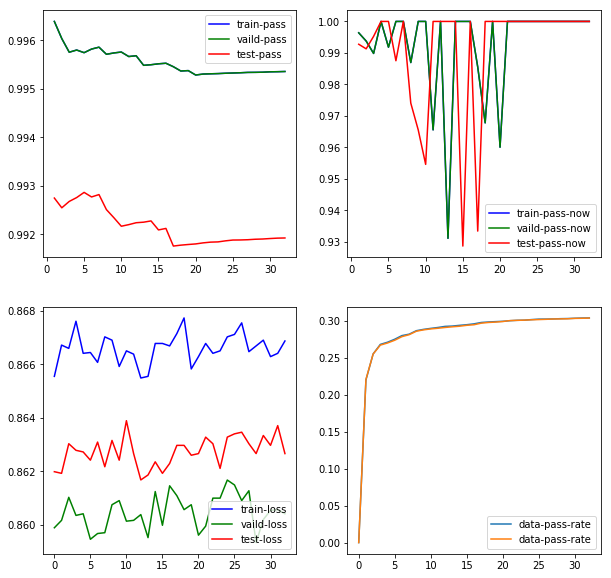

In [18]:
# 0123
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.plot(x,pass_data_rate_test_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

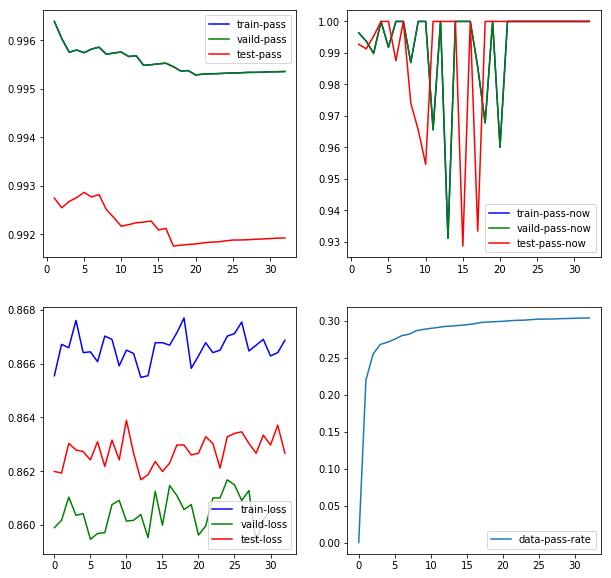

In [53]:
# 0130
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

In [54]:
pass_data_rate_lt

[0.0,
 0.22007247712057,
 0.2553282967876666,
 0.26828818868619864,
 0.2712364105398931,
 0.275290215588723,
 0.2802039186782138,
 0.2821079786253915,
 0.2868374178490264,
 0.2886186352189668,
 0.28996990356857677,
 0.29119832934094947,
 0.2926724402677967,
 0.29310238928812715,
 0.2940851299060253,
 0.2949450279466862,
 0.29611203243044026,
 0.2979546710889993,
 0.2986303052638043,
 0.2991216755727534,
 0.2995516245930838,
 0.3003501013451261,
 0.3009028929426938,
 0.3010871568085497,
 0.30188563356059195,
 0.3024998464467783,
 0.30256126773539693,
 0.30274553160125284,
 0.30311405933296465,
 0.30329832319882055,
 0.30366685093053236,
 0.30397395737362554,
 0.3040967999508628]

In [19]:
pass_data_rate_test_lt

[0,
 0.22078560240778847,
 0.2552440035625442,
 0.26731365744295327,
 0.2701698350787753,
 0.273916648751574,
 0.2787690795737232,
 0.2814102760971715,
 0.2861091489819109,
 0.2879518442308283,
 0.2892417309050705,
 0.29013236694204725,
 0.29120727250391576,
 0.2920979085408925,
 0.2928964098154234,
 0.2941248733147017,
 0.29489266300175065,
 0.2970117625380057,
 0.2979638217499464,
 0.29848591873713964,
 0.2992537084241886,
 0.3005128835109488,
 0.30085071097325033,
 0.30112711526058794,
 0.3015877890728173,
 0.3018949049476369,
 0.3022327324099384,
 0.3026934062221678,
 0.30278554098461363,
 0.3029698105095054,
 0.30349190749669863,
 0.3036454654341084,
 0.303921869721446]

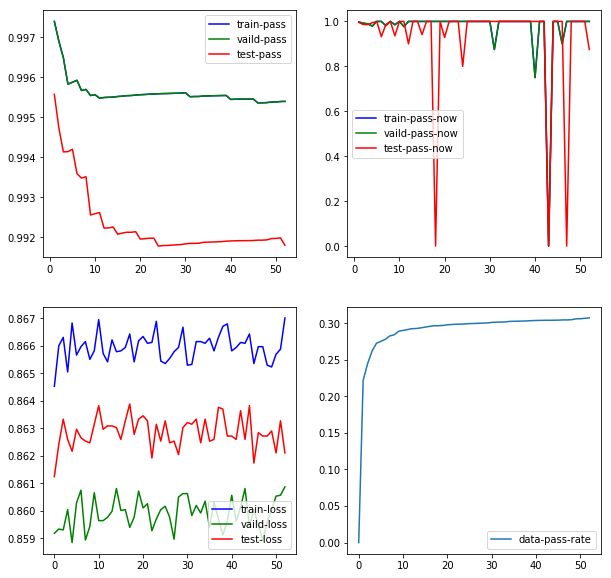

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
plt.plot(x,train_loss_lt, label="train-loss", color="blue")
plt.plot(x,vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

In [201]:
pass_test_loss_lt_now[1:]

[0.99928977272727271,
 0.99489795918367352,
 1.0,
 1.0,
 1.0,
 0.98958333333333337,
 0.99212598425196852,
 0.99270072992700731,
 1.0,
 0.90909090909090906,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.94999999999999996,
 1.0]

In [145]:
print("data auc", metrics.roc_auc_score(y_sub, test_y))
print("data log", metrics.log_loss(y_sub, test_y))
print("data acc", acc_prob(y_sub, test_y))

data auc 0.913834654713
data log 0.306926614716
data acc 0.861494994165


# Todo list
- 树结构设计（完成）
- 通过gini对数据分割（完成）
- 全局测试集
- 输出结果集
- 打印信息增加pass data的比例
- 防止过拟合
- 对pass data的进一步处理
- 先进行数据均衡化是不是更快一些